# Import Dependencies

In [46]:
# Import tensorflow functional API

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential


# Import useful package

import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Extract LFW file

!tar -xf lfw.tgz

In [2]:
# Setup directory path

POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANCHOR_PATH = os.path.join('data', 'anchor')

In [3]:
target_shape = (100, 100)

def preprocess_image(filename):
  image_string = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image_string, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, target_shape)
  return image


preprocess_image("data\\anchor\\s15.jpg")

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.18431373, 0.18431373, 0.18431373],
        [0.16862746, 0.16862746, 0.16862746],
        [0.19607845, 0.19607845, 0.19607845],
        ...,
        [0.21176472, 0.21176472, 0.21176472],
        [0.21176472, 0.21176472, 0.21176472],
        [0.20784315, 0.20784315, 0.20784315]],

       [[0.20784315, 0.20784315, 0.20784315],
        [0.1764706 , 0.1764706 , 0.1764706 ],
        [0.1764706 , 0.1764706 , 0.1764706 ],
        ...,
        [0.23529413, 0.23529413, 0.23529413],
        [0.2392157 , 0.2392157 , 0.2392157 ],
        [0.23137257, 0.23137257, 0.23137257]],

       [[0.21568629, 0.21568629, 0.21568629],
        [0.18431373, 0.18431373, 0.18431373],
        [0.16862746, 0.16862746, 0.16862746],
        ...,
        [0.18431373, 0.18431373, 0.18431373],
        [0.19607845, 0.19607845, 0.19607845],
        [0.20784315, 0.20784315, 0.20784315]],

       ...,

       [[0.18823531, 0.18823531, 0.18823531],
        [0.18

In [4]:
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [5]:
# Create Triplets Pair Dataset using tf.data.Dataset

anchor_sorted_filename = sorted(os.listdir(ANCHOR_PATH), key=lambda filename: int(filename.split('.')[0][1:]))
anchor_images = [str(ANCHOR_PATH + '\\' + f) for f in anchor_sorted_filename]

positive_sorted_filename = sorted(os.listdir(POS_PATH), key=lambda filename: int(filename.split('.')[0][1:]))
positive_images = [str(POS_PATH + '\\' + f) for f in positive_sorted_filename]

negative_sorted_filename = sorted(os.listdir(NEG_PATH))
negative_images = [str(NEG_PATH + '\\' + f) for f in negative_sorted_filename]


anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

print(len(dataset))


200


In [9]:
# Split training dan validation dataset

image_count = len(dataset)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

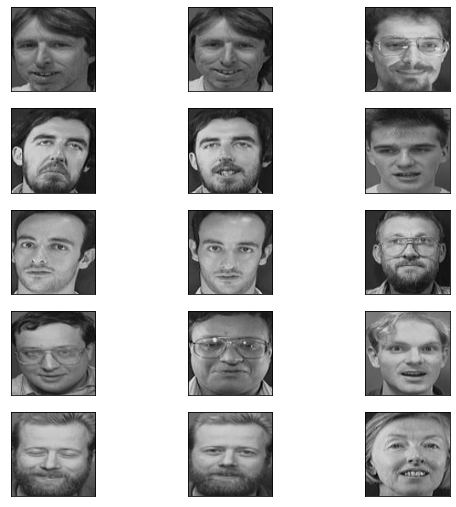

In [10]:
def visualize(anchor, positive, negative):

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(5, 3)
    for i in range(5):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(2).as_numpy_iterator())[0])

In [11]:
ResNetCNN = resnet.ResNet50(
  weights="imagenet", input_shape=target_shape + (3, ), include_top=False
)

Flatten = layers.Flatten()(ResNetCNN.output)
Dense1 = layers.Dense(512, activation="relu")(Flatten)
Dense1 = layers.BatchNormalization()(Dense1)
Dense2 = layers.Dense(256, activation="relu")(Dense1)
Dense2 = layers.BatchNormalization()(Dense2)
Output = layers.Dense(256)(Dense2)

trainable = False
for layer in ResNetCNN.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

Embeddings = Model(ResNetCNN.input, Output, name="Embeddings")

Embeddings.summary()

Model: "Embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
_________________________________________________________________________________________

In [12]:
class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return (ap_distance, an_distance)

In [13]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

Distances = DistanceLayer()(
    Embeddings(resnet.preprocess_input(anchor_input)),
    Embeddings(resnet.preprocess_input(positive_input)),
    Embeddings(resnet.preprocess_input(negative_input)),
)

SiameseNetwork = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=Distances, name="Siamese"
)

In [14]:
class SiameseModel(Model):

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]


In [135]:
siamese_model = SiameseModel(SiameseNetwork)
siamese_model.build(input_shape=[(None, 100, 100, 3), (None, 100, 100, 3), (None, 100, 100, 3)])
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
5/5 [==============================] - 15s 1s/step - loss: 0.0274 - val_loss: 0.0181
Epoch 2/10
5/5 [==============================] - 4s 897ms/step - loss: 0.1059 - val_loss: 0.0030
Epoch 3/10
5/5 [==============================] - 4s 939ms/step - loss: 0.0432 - val_loss: 0.0201
Epoch 4/10
5/5 [==============================] - 4s 932ms/step - loss: 0.0097 - val_loss: 0.0209
Epoch 5/10
5/5 [==============================] - 5s 961ms/step - loss: 0.0192 - val_loss: 0.0073
Epoch 6/10
5/5 [==============================] - 4s 939ms/step - loss: 0.0197 - val_loss: 0.0121
Epoch 7/10
5/5 [==============================] - 5s 942ms/step - loss: 0.0147 - val_loss: 0.0000e+00
Epoch 8/10
5/5 [==============================] - 4s 930ms/step - loss: 0.0045 - val_loss: 0.0128
Epoch 9/10
5/5 [==============================] - 5s 946ms/step - loss: 0.0055 - val_loss: 0.0000e+00
Epoch 10/10
5/5 [==============================] - 4s 937ms/step - loss: 0.0067 - val_loss: 0.0179


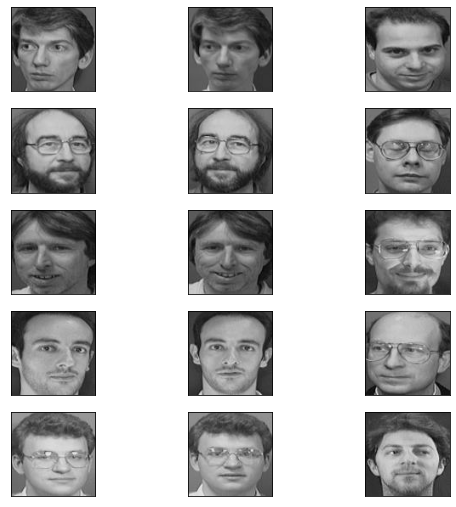

In [136]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    Embeddings(resnet.preprocess_input(anchor)),
    Embeddings(resnet.preprocess_input(positive)),
    Embeddings(resnet.preprocess_input(negative)),
)

In [138]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9999668
Negative similarity 0.9999045


In [140]:
# Input is same with anchor

anchor_image = preprocess_image('./data/anchor/s15.jpg')
input_image = preprocess_image('./data/positive/s10.jpg')
negative_image = preprocess_image('./data/negative/1.jpg')

anchor_image_embedding = Embeddings(anchor_image[None, :, :, :])
postive_image_embedding = Embeddings(input_image[None, :, :, :])
negative_image_embedding = Embeddings(negative_image[None, :, :, :])

cosine_similarity.reset_state()

positive_similarity = cosine_similarity(anchor_image_embedding, postive_image_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_image_embedding, negative_image_embedding)
print("Negative similarity", negative_similarity.numpy())

ap_distance = tf.reduce_sum(tf.square(anchor_image_embedding - postive_image_embedding), axis=-1)
an_distance = tf.reduce_sum(tf.square(anchor_image_embedding - negative_image_embedding), axis=-1)

print(ap_distance)
print(an_distance)

is_same = positive_similarity.numpy() > negative_similarity.numpy()

print("Is same person: {}".format(is_same))

Positive similarity: 0.9999656
Negative similarity 0.9999266
tf.Tensor([0.61942375], shape=(1,), dtype=float32)
tf.Tensor([3.3442101], shape=(1,), dtype=float32)
Is same person: True


In [141]:
# Input is different with anchor

anchor_image = preprocess_image('./data/anchor/s29.jpg')
input_image = preprocess_image('./data/positive/s41.jpg')
negative_image = preprocess_image('./data/negative/2.jpg')

anchor_image_embedding = Embeddings(anchor_image[None, :, :, :])
postive_image_embedding = Embeddings(input_image[None, :, :, :])
negative_image_embedding = Embeddings(negative_image[None, :, :, :])

cosine_similarity.reset_state()

positive_similarity = cosine_similarity(anchor_image_embedding, postive_image_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_image_embedding, negative_image_embedding)
print("Negative similarity", negative_similarity.numpy())

ap_distance = tf.reduce_sum(tf.square(anchor_image_embedding - postive_image_embedding), axis=-1)
an_distance = tf.reduce_sum(tf.square(anchor_image_embedding - negative_image_embedding), axis=-1)

print(ap_distance)
print(an_distance)

is_same = positive_similarity.numpy() > negative_similarity.numpy()

print("Is same person: {}".format(is_same))

Positive similarity: 0.99988747
Negative similarity 0.9999021
tf.Tensor([4.462976], shape=(1,), dtype=float32)
tf.Tensor([4.2401257], shape=(1,), dtype=float32)
Is same person: False


In [146]:
siamese_model.compute_output_shape([(None, 100, 100, 3), (None, 100, 100, 3), (None, 100, 100, 3)])
tf.saved_model.save(siamese_model, "./models/model_1st")

INFO:tensorflow:Assets written to: ./models/model_1st\assets


In [ ]:
siamese_model.get_layer("Siamese").get_layer("Embeddings").summary()

In [160]:
siamese_model.save("./models/keras_model_1st")

INFO:tensorflow:Assets written to: ./models/keras_model_1st\assets


d:\Github Repo\precencia\env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [15]:
keras_saved_model = tf.keras.models.load_model(
    "./models/keras_model_1st", custom_objects={"SiameseModel": SiameseModel}
)

In [38]:
embeddings = keras_saved_model.get_layer("Siamese").get_layer("Embeddings")

cosine_similarity = metrics.CosineSimilarity()

# Input is different with anchor

BASE = "./data/test"

anchor_name = "jayaku"
input_name = "jayaku"

anchor_image_path = BASE + "/anchor/" + anchor_name + ".jpg"
input_image_path = BASE + "/input/" + input_name + "/5.jpg"
negative_image_path = BASE + "/negative/man.jpg"

anchor_image = preprocess_image(anchor_image_path)
input_image = preprocess_image(input_image_path)
negative_image = preprocess_image(negative_image_path)

anchor_image_embedding = embeddings(anchor_image[None, :, :, :])
postive_image_embedding = embeddings(input_image[None, :, :, :])
negative_image_embedding = embeddings(negative_image[None, :, :, :])

positive_similarity = cosine_similarity(anchor_image_embedding, postive_image_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_image_embedding, negative_image_embedding)
print("Negative similarity", negative_similarity.numpy())

ap_distance = tf.reduce_sum(tf.square(anchor_image_embedding - postive_image_embedding), axis=-1)
an_distance = tf.reduce_sum(tf.square(anchor_image_embedding - negative_image_embedding), axis=-1)

print(ap_distance)
print(an_distance)

is_same = positive_similarity.numpy() >  negative_similarity.numpy()

print("Is same person: {}".format(is_same))

Positive similarity: 0.9999827
Negative similarity 0.9998424
tf.Tensor([0.30318344], shape=(1,), dtype=float32)
tf.Tensor([7.6325693], shape=(1,), dtype=float32)
Is same person: True


In [18]:
embeddings = keras_saved_model.get_layer("Siamese").get_layer("Embeddings")

def extract_embeddings(image_path):
  image = preprocess_image(image_path)
  return embeddings(image[None, :, :, :])

In [19]:
pair_embeddings = []
y = []

length = len(anchor_images)

for idx in range(length):
  pair_embeddings.append((extract_embeddings(anchor_images[idx]).numpy(), extract_embeddings(positive_images[idx]).numpy()))
  y.append(1)
  pair_embeddings.append((extract_embeddings(anchor_images[idx]).numpy(), extract_embeddings(negative_images[idx]).numpy()))
  y.append(0)

In [195]:
X = []

for embedding in pair_embeddings:
  X.append(np.array(embedding[0] - embedding[1]).reshape(-1))

y = np.array(y).reshape(-1)
X = np.array(X)

In [196]:
logistic_classifier = Sequential()
logistic_classifier.add(layers.Input(shape=(256,)))
logistic_classifier.add(layers.Dense(64, activation='relu'))
logistic_classifier.add(layers.Dense(1, activation='sigmoid'))
logistic_classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

logistic_history = logistic_classifier.fit(X, y, epochs=128)

Epoch 1/128
13/13 [==============================] - 1s 5ms/step - loss: 0.6856 - accuracy: 0.5500
Epoch 2/128
13/13 [==============================] - 0s 5ms/step - loss: 0.6586 - accuracy: 0.5850
Epoch 3/128
13/13 [==============================] - 0s 5ms/step - loss: 0.6515 - accuracy: 0.6175
Epoch 4/128
13/13 [==============================] - 0s 5ms/step - loss: 0.6425 - accuracy: 0.6575
Epoch 5/128
13/13 [==============================] - 0s 5ms/step - loss: 0.6336 - accuracy: 0.6650
Epoch 6/128
13/13 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6950
Epoch 7/128
13/13 [==============================] - 0s 5ms/step - loss: 0.6148 - accuracy: 0.7275
Epoch 8/128
13/13 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.7450
Epoch 9/128
13/13 [==============================] - 0s 5ms/step - loss: 0.5951 - accuracy: 0.7525
Epoch 10/128
13/13 [==============================] - 0s 5ms/step - loss: 0.5859 - accuracy: 0.7625
Epoch 11/

In [197]:
logistic_classifier.predict(X[:10])

array([[0.95876557],
       [0.15470773],
       [0.78362876],
       [0.11883559],
       [0.8009949 ],
       [0.06726705],
       [0.7462513 ],
       [0.08776619],
       [0.95616513],
       [0.004176  ]], dtype=float32)

In [198]:
logistic_classifier.save("./models/keras_logistic_model_1st")

INFO:tensorflow:Assets written to: ./models/keras_logistic_model_1st\assets


In [219]:
BASE = "./data/test"

anchor_name = "jayaku"
input_name = "amalia"

anchor_image_path = BASE + "/anchor/" + anchor_name + ".jpg"
input_image_path = BASE + "/input/" + input_name + "/1.jpg"

anchor_embedding = extract_embeddings(anchor_image_path).numpy()
input_embedding = extract_embeddings(input_image_path).numpy()

difference_embedding = np.array(anchor_embedding - input_embedding).reshape(-1)

logistic_classifier.predict(np.array([difference_embedding]))

array([[0.00433333]], dtype=float32)